# Packages

In [1]:
# Packages
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import random
from datetime import date, datetime
from pandas.tseries.frequencies import to_offset
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

sns.set_theme(style="darkgrid")
from mpl_toolkits.mplot3d import Axes3D
from tabulate import tabulate
from stargazer.stargazer import Stargazer


# import plotly.graph_objects as go
import copy
import yfinance as yf
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, SVAR
import statsmodels.tsa.vector_ar.svar_model as svar
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.filters.hp_filter import hpfilter
from scipy.stats import pearsonr
import requests as req

from fredapi import Fred
fred = Fred(api_key="ef7244731efdde9698fef5d547b7094f")

# Pfade

In [2]:
path_ma_data = r"C:\Users\alexa\Documents\Studium\MSc (WU)\Master Thesis\Analysis\Data"
path_ma_figures = r"C:\Users\alexa\Documents\Studium\MSc (WU)\Master Thesis\Analysis"

# Functions

In [3]:
# Beta 1 Loading
def beta_1_loading(lmda, maturity):
    result = (1 - np.exp(-lmda * maturity)) / (lmda * maturity)
    return result


# Beta 2 Loading
def beta_2_loading(lmda, maturity):
    result = (1 - np.exp(-lmda * maturity)) / (lmda * maturity) - np.exp(
        -lmda * maturity
    )
    return result

# Data

In [5]:
# Data
# NBER Recession Dates
us_rec = fred.get_series("USREC")

# us_rec.loc["1970":].plot.area(color="lightgray", alpha=0.5)

# FED Yield Curva Factors
fed_factors = pd.read_csv(path_ma_data + "\\" + "feds200628.csv", 
                          skiprows=9,
                          index_col=[0])

fed_factors.index = pd.to_datetime(fed_factors.index)


# Extract zero-coupon yields for R NS Analysis
# cols_ns_r = [col for col in fed_factors.columns if "SVENY" in col]
# fed_factors[cols_ns_r].to_csv(path_ma + "\\" + "FED_Yields.csv")



fed_factors_m = fed_factors.resample("M").mean()
fed_factors_m.index = fed_factors_m.index + pd.DateOffset(days=1)

# Plots

## Plots Factor Loadings

C:\Users\alexa\AppData\Local\Temp\ipykernel_21368\3500723618.py:3: RuntimeWarning: invalid value encountered in scalar divide
  result = (1 - np.exp(-lmda * maturity)) / (lmda * maturity)
C:\Users\alexa\AppData\Local\Temp\ipykernel_21368\3500723618.py:9: RuntimeWarning: invalid value encountered in scalar divide
  result = (1 - np.exp(-lmda * maturity)) / (lmda * maturity) - np.exp(


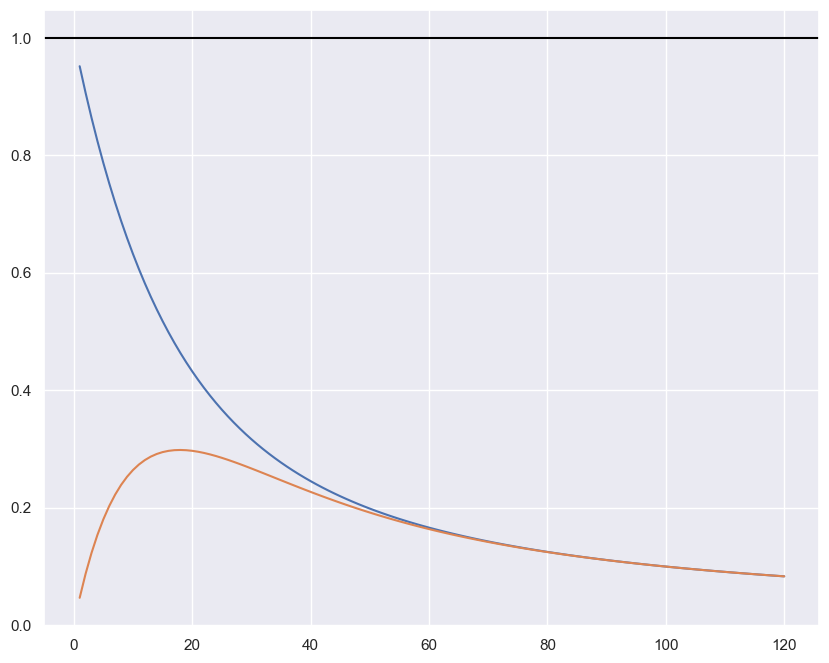

In [6]:
maturities = [mat for mat in range(0, 121)]

lmda = 0.1

dict_beta_1_loading = {}
dict_beta_2_loading = {}

for mat in maturities:
    result_1 = beta_1_loading(lmda=lmda, maturity=mat)
    dict_beta_1_loading[mat] = result_1
    
    result_2 = beta_2_loading(lmda=lmda, maturity=mat)
    dict_beta_2_loading[mat] = result_2
    


# Plot Loadings
plt.figure(figsize=(10, 8))

plt.axhline(y=1, color="black", label="Level Factor Loading")
plt.plot(
    list(dict_beta_1_loading.keys()),
    list(dict_beta_1_loading.values()),
    label="Slope Factor Loading",
)
plt.plot(
    list(dict_beta_2_loading.keys()),
    list(dict_beta_2_loading.values()),
    label="Curvature Factor Loading",
)




### ChatGPT 

In [6]:
dict_beta_1_loading

{0.1: {0: nan,
  1: 0.9516258196404048,
  2: 0.9063462346100909,
  3: 0.8639392643942736,
  4: 0.8241998849109017,
  5: 0.7869386805747332,
  6: 0.7519806065099559,
  7: 0.719163851726558,
  8: 0.688338794853473,
  9: 0.6593670447326676,
  10: 0.6321205588285577,
  11: 0.6064808330017458,
  12: 0.5823381567398316,
  13: 0.559590928435375,
  14: 0.5381450257559953,
  15: 0.5179132265677134,
  16: 0.49881467625334036,
  17: 0.4807743976160384,
  18: 0.46372283987689633,
  19: 0.4475954635670341,
  20: 0.43233235838169365,
  21: 0.4178778913081039,
  22: 0.4041803825625755,
  23: 0.3911918070770418,
  24: 0.3788675194627448,
  25: 0.36716600055044046,
  26: 0.3560486237637177,
  27: 0.3454794397260186,
  28: 0.3354249776338507,
  29: 0.3258540620495147,
  30: 0.3167376438773787,
  31: 0.3080486443891749,
  32: 0.29976181125676055,
  33: 0.29185358563598784,
  34: 0.2843019794234335,
  35: 0.27708646187933755,
  36: 0.2701878548757521,
  37: 0.2635882360890974,
  38: 0.2572708495115354,
  

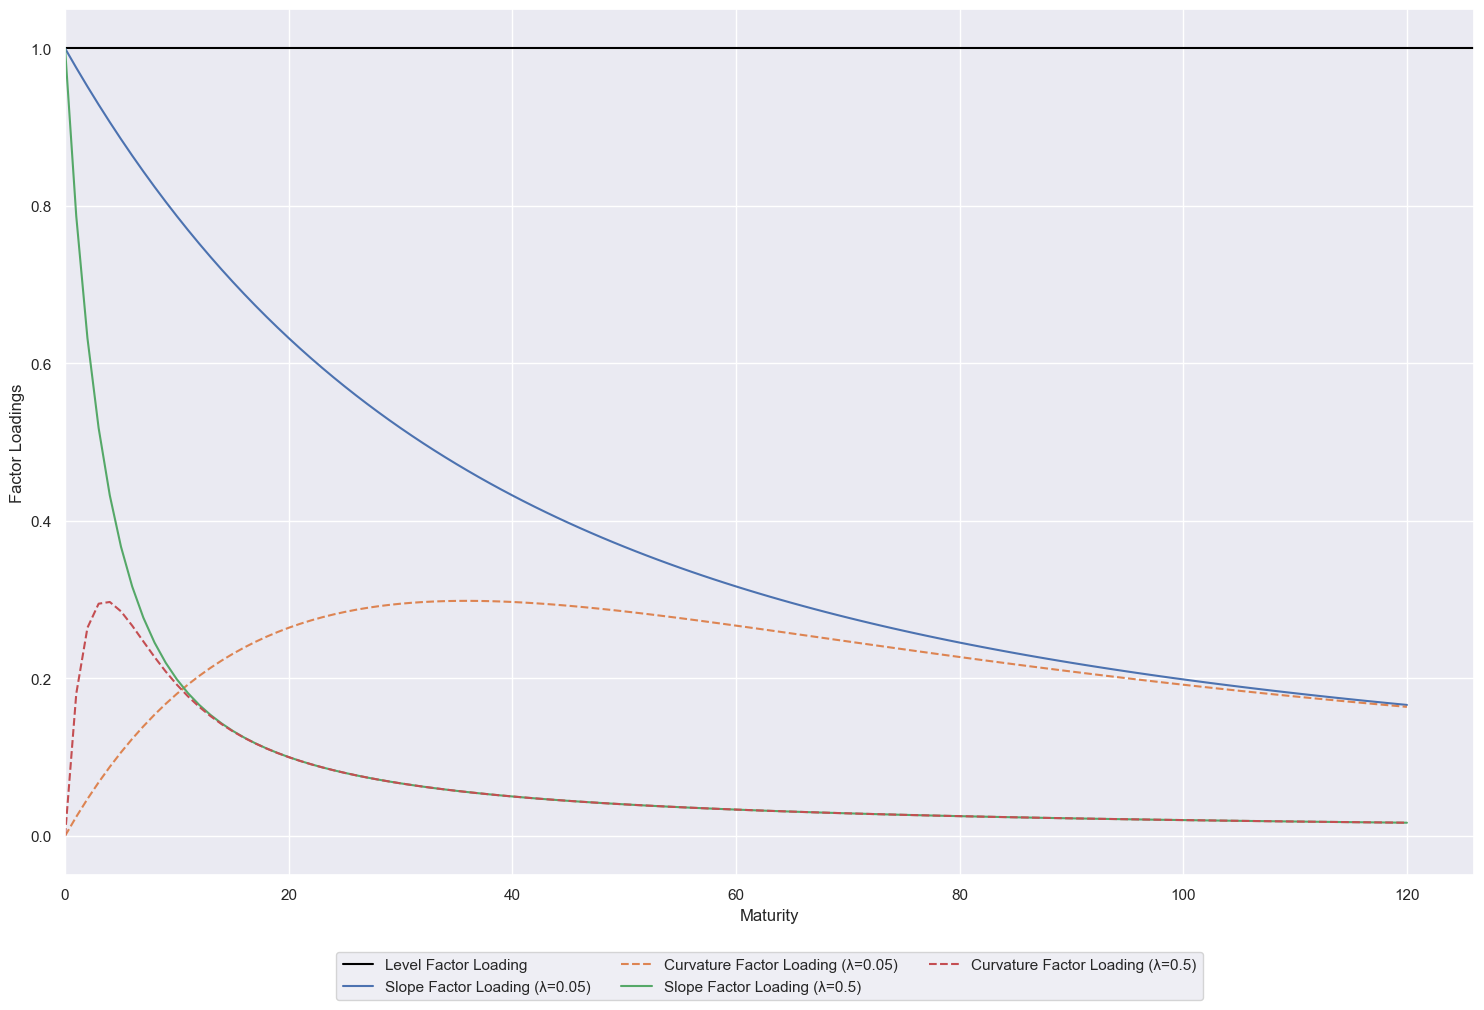

In [7]:
# List of maturities
maturities = [mat for mat in range(0, 121)]

# List of lambda values you want to use
lambdas = [0.05, 0.5]  # Add more lambda values if needed

# Create dictionaries to store the loadings for each lambda
dict_beta_1_loading = {lmda: {} for lmda in lambdas}
dict_beta_2_loading = {lmda: {} for lmda in lambdas}


# Insert value 1/0 for maturity 0 for all lambdas in both dict_beta_1_loading and dict_beta_2_loading
for lmda in lambdas:
    dict_beta_1_loading[lmda][0] = 1
    dict_beta_2_loading[lmda][0] = 0

# Loop over lambdas and maturities to calculate the loadings
for lmda in lambdas:
    for mat in maturities[1:]:  # Skip maturity 0 since we already set it
        result_1 = beta_1_loading(lmda=lmda, maturity=mat)
        dict_beta_1_loading[lmda][mat] = result_1

        result_2 = beta_2_loading(lmda=lmda, maturity=mat)
        dict_beta_2_loading[lmda][mat] = result_2
        
        
        
# Plot Loadings
plt.figure(figsize=(15, 10))

# Level factor loading line
plt.axhline(y=1, color="black", label="Level Factor Loading")

# Loop over lambdas and plot each one dynamically
for lmda in lambdas:
    plt.plot(
        list(dict_beta_1_loading[lmda].keys()),
        list(dict_beta_1_loading[lmda].values()),
        label=f"Slope Factor Loading (λ={lmda})",
    )
    plt.plot(
        list(dict_beta_2_loading[lmda].keys()),
        list(dict_beta_2_loading[lmda].values()),
        label=f"Curvature Factor Loading (λ={lmda})",
        linestyle="--",
    )

# x-axis starts at 0
plt.xlim(left=0)
# Add legend centrally below the x-axis
plt.legend()
plt.xlabel("Maturity")
plt.ylabel("Factor Loadings")
# plt.title("Factor Loadings for Different Lambda Values")

# Adjust layout to make space for the legend before saving
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Add legend centrally below the x-axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.08), ncol=3)

plt.savefig(path_ma_figures + "\\" + "Factor_Loadings_Lambdas.pdf", bbox_inches="tight", dpi=1000)

plt.show()


## Plot YC Factors